In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [3]:
file_1 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/clicks__data.csv"
file_2 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/views__data.csv"
file_3 = "C:/Users/Efrem/Downloads/meesho_statement_2/DICE Challenge Business Analytics Case 2/orders__table.csv"

In [4]:
click_data = pd.read_csv(file_1)
view_data = pd.read_csv(file_2)
order_data = pd.read_csv(file_3)

In [16]:
data = order_data.copy()
data['clicks_count'] = click_data['clicks_count']
data['app_open_count'] = view_data['app_open_count']
data['order_date'] = pd.to_datetime(data['order_date'])
df = data.copy()
data

,order_id,order_date,user_id,order_value,category,quantity,order_status,supplier_id,feedback,clicks_count,app_open_count
0,0,2023-09-26,14225,4044.37,Home Goods,1,cancelled,565,Negative feedback,1,4
1,1,2024-09-08,19369,2969.24,Clothing,10,cancelled,222,Positive feedback,11,46
2,2,2024-03-08,339,4985.45,Electronics,2,cancelled,907,Neutral feedback,44,48
3,3,2023-11-26,19310,4328.57,Clothing,4,delivered,176,Neutral feedback,37,42
4,4,2023-11-20,13523,2517.05,Home Goods,1,delivered,207,Negative feedback,10,19
...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,2023-10-04,11904,896.17,Home Goods,9,cancelled,769,Negative feedback,16,35
999996,999996,2023-12-14,83686,828.17,Clothing,5,returned,968,Positive feedback,7,27
999997,999997,2024-07-09,37213,4156.44,Electronics,6,delivered,745,Neutral feedback,6,7
999998,999998,2024-08-17,99950,4931.21,Home Goods,6,exchanged,423,Negative feedback,5,8


In [6]:
max_date = data['order_date'].max()
min_date = data['order_date'].min()
unique_customers = data['user_id'].nunique()
unique_suppliers = data['supplier_id'].nunique()
total_orders = data['order_id'].nunique()
total_quantity = data['quantity'].sum()
total_sales = data['order_value'].sum()

print(f"Date Range : {min_date} to {max_date}")
print(f"Total number of Customers : {unique_customers}")
print(f"Total number of Suppliers : {unique_suppliers}")
print(f"Total number of Orders : {total_orders}")
print(f"Total number of Quantity Sold : {total_quantity}")
print(f"Total Sales : {total_sales}")

Date Range : 2023-09-12 00:00:00 to 2024-09-10 00:00:00
Total number of Customers : 99989
Total number of Suppliers : 1000
Total number of Orders : 1000000
Total number of Quantity Sold : 5500335
Total Sales : 2500132333.99


In [7]:
# Function to calculate RFM
def calculate_rfm(df, customer_id_col, order_id_col, order_date_col, order_value_col, snapshot_date=None):
    """
    Calculate RFM (Recency, Frequency, and Monetary) values for customers.

    Parameters:
    df (pd.DataFrame): DataFrame containing customer data.
    customer_id_col (str): The column name for the customer ID.
    order_date_col (str): The column name for the order date.
    order_value_col (str): The column name for the order value.
    snapshot_date (str or datetime, optional): The date to calculate recency against (default is today).

    Returns:
    pd.DataFrame: DataFrame with customer_id, Recency, Frequency, and Monetary values.
    """

    # Set the snapshot date (for recency calculation), default is today if not provided
    if snapshot_date is None:
        snapshot_date = datetime.today()
    else:
        snapshot_date = pd.to_datetime(snapshot_date)
    
    # Ensure the order_date_col is in datetime format
    df[order_date_col] = pd.to_datetime(df[order_date_col])
    
    # Ensure that only delivered / exchanged orders are accounted for monetary calculation
    filtered_df = df[df['order_status'].isin(['delivered', 'exchanged'])]
    filtered_df = filtered_df.groupby(customer_id_col).agg({order_value_col : 'sum'}).reset_index()

    # Calculate Recency: difference between the snapshot date and the last order date
    rfm_df = df.groupby(customer_id_col).agg({
        order_date_col: lambda x: (snapshot_date - x.max()).days,  # Recency
        order_id_col: 'count',  # Frequency
    }).reset_index()
    
    # Merging the DataFrames on 'user_id'
    merged_df = pd.merge(rfm_df, filtered_df, on=customer_id_col, how='left')

    # Replacing NaN values with 0
    merged_df[order_value_col] = merged_df[order_value_col].fillna(0)

    # Rename columns to Recency, Frequency, and Monetary
    merged_df.columns = [customer_id_col, 'Recency', 'Frequency', 'Monetary']

    return merged_df

In [8]:
# Function to map feedback and calculate the weighted feedback score
def calculate_feedback(df, customer_id_col, feedback_col, feedback_date_col, today, recent_threshold=30, alpha=0.7, beta=0.3):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    feedback_col (str): Column name for feedback (positive/negative/neutral).
    feedback_date_col (str): Column name for feedback date.
    today (str): The last date / latest date wrt which the recency will be calculated.
    recent_threshold (int): Number of days to classify feedback as 'recent'. Default is 30 days.
    alpha (float): Weight for recent feedback. Default is 0.7.
    beta (float): Weight for older feedback. Default is 0.3.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    # Step 1: Map the feedback to numerical scores
    feedback_mapping = {
        'Positive feedback': 1,
        'Neutral feedback': 0,
        'Negative feedback': -1
    }
    df['feedback_mapped'] = df[feedback_col].map(feedback_mapping)
    
    # Convert feedback_date_col to datetime if not already
    df[feedback_date_col] = pd.to_datetime(df[feedback_date_col])
    
    # Step 2: Calculate days since feedback was provided
    if not today :
        today = pd.to_datetime("today")
    df['days_since_feedback'] = (today - df[feedback_date_col]).dt.days
    
    # Step 3: Classify feedback as 'recent' or 'older'
    df['feedback_type'] = df['days_since_feedback'].apply(lambda x: 'recent' if x <= recent_threshold else 'older')
    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_feedback'] = df.apply(lambda x: alpha * x['feedback_mapped'] if x['feedback_type'] == 'recent' 
                                       else beta * x['feedback_mapped'], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    feedback_df = df.groupby(customer_id_col).agg({
        'weighted_feedback': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    feedback_df.columns = [customer_id_col, 'Weighted Feedback Score']
    
    return feedback_df

In [9]:
# Function to map feedback and calculate the weighted feedback score
def calculate_interaction(df, customer_id_col, clicks_count_col, app_open_count_col, alpha=1, beta=2):
    """
    Function to map feedback to a numerical score and calculate weighted feedback based on recency.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with feedback data.
    customer_id_col (str): The column name for the customer ID.
    clicks_count_col (str): Column name for number of clicks.
    app_open_count_col (str): Column name for number of times the app was opened.
    alpha (float): Weight for app opens. Default is 1.
    beta (float): Weight for clicks. Default is 2.
    
    Returns:
    pd.DataFrame: DataFrame with the weighted feedback scores.
    """

    
    # Step 4: Calculate the weighted feedback score based on recency
    df['weighted_interaction_score'] = df.apply(lambda x: alpha * x[app_open_count_col] + beta * x[clicks_count_col], axis=1)
    
    # Step 5: Group the by customer_id and sum the weighted scores
    interaction_df = df.groupby(customer_id_col).agg({
        'weighted_interaction_score': 'sum'
    }).reset_index()

    # Rename columns to Recency, Frequency, and Monetary
    interaction_df.columns = [customer_id_col, 'Weighted Interaction Score']
    
    return interaction_df

In [10]:
x = calculate_rfm(data,'user_id','order_id','order_date','order_value',max_date)
y = calculate_feedback(data,'user_id','feedback','order_date',max_date)
z = calculate_interaction(data,'user_id','clicks_count','app_open_count')
x['Feedback'] = y['Weighted Feedback Score']
x['Interaction'] = z['Weighted Interaction Score']
x

,user_id,Recency,Frequency,Monetary,Feedback,Interaction
0,1,17,14,18845.53,-1.20,803
1,2,6,13,7088.22,1.00,580
2,3,12,8,6241.12,-0.80,465
3,4,42,14,13920.68,-2.10,822
4,5,6,9,6851.89,-2.20,201
...,...,...,...,...,...,...
99984,99996,0,10,9310.30,-1.00,516
99985,99997,13,8,5169.92,-1.60,355
99986,99998,44,11,9319.30,-1.20,694
99987,99999,23,12,7943.73,-0.40,764


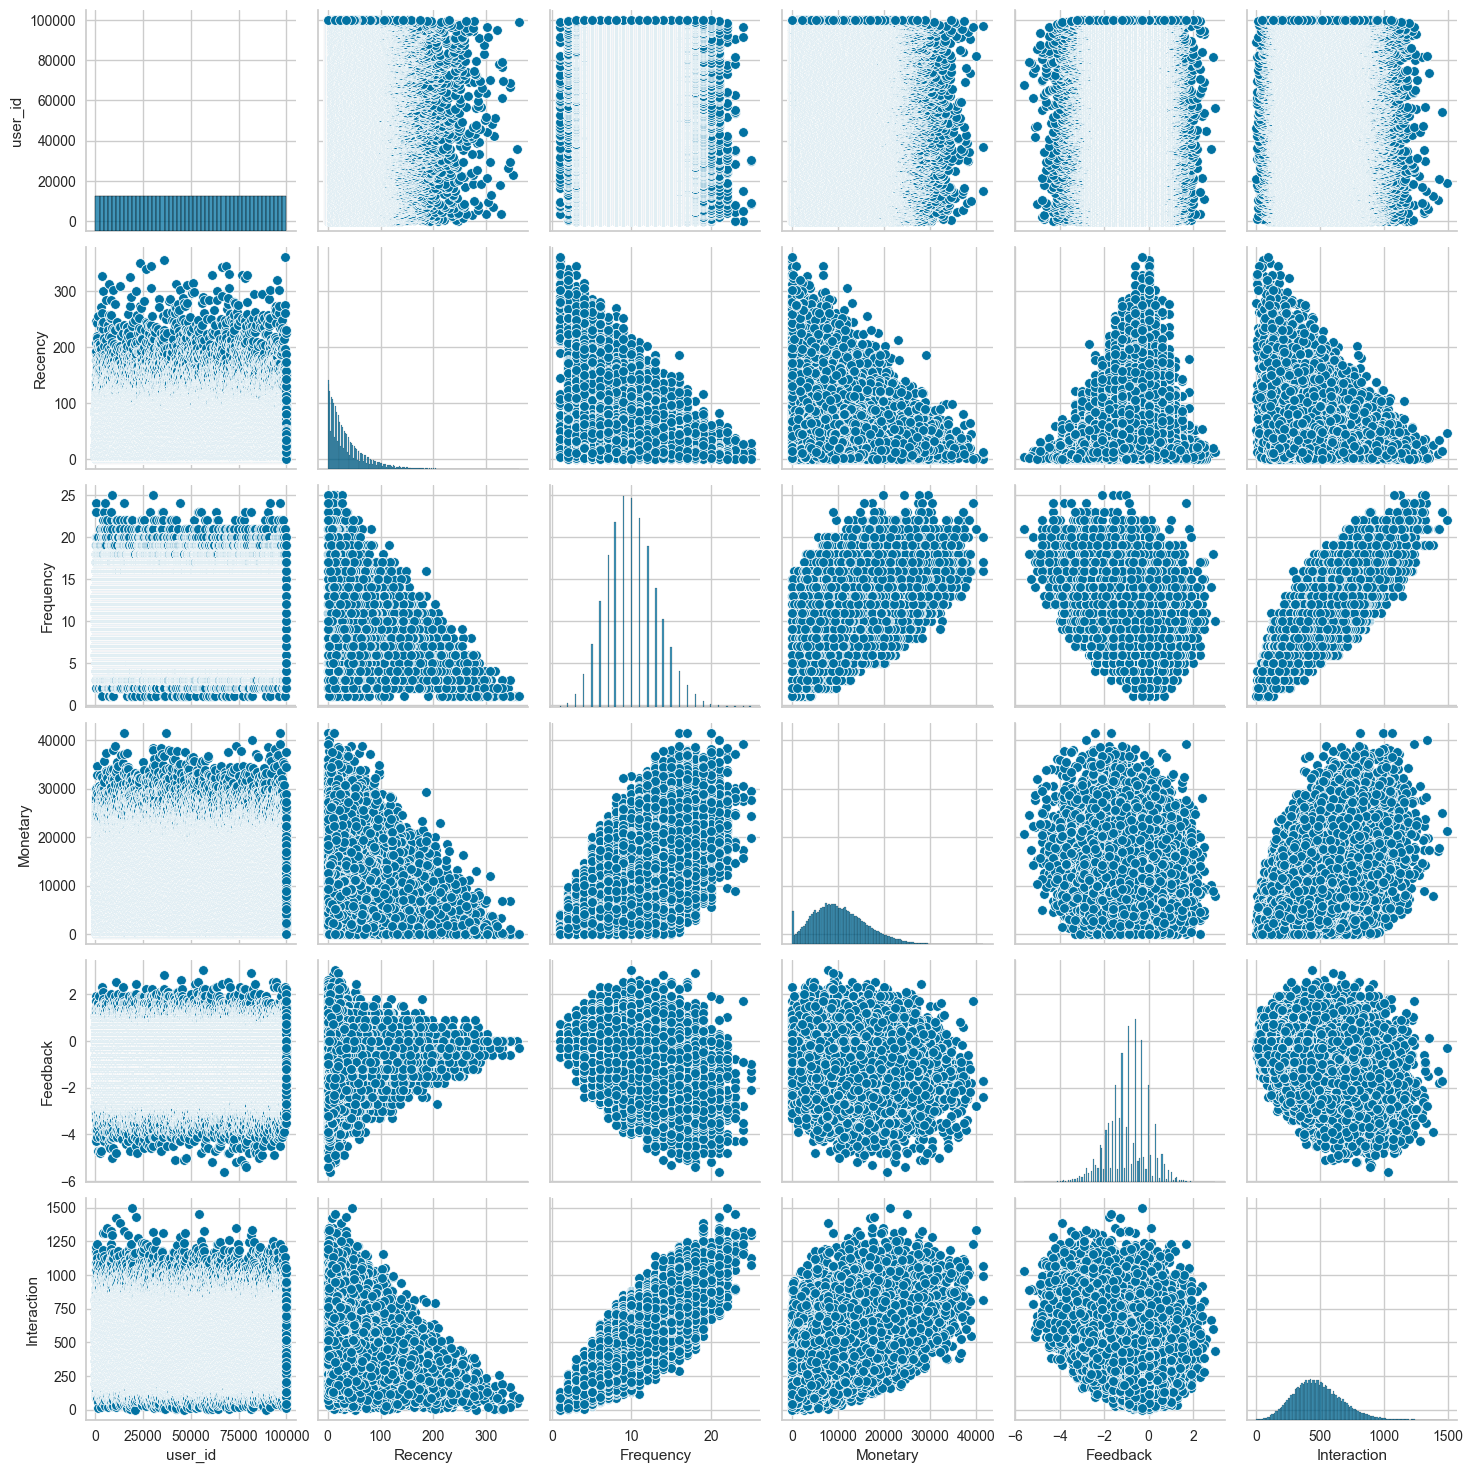

In [11]:
sns.pairplot(x)

In [17]:
# Step 1: Map the feedback to numerical scores
feedback_mapping = {
    'Positive feedback': 1,
    'Neutral feedback': 0,
    'Negative feedback': -1
}
df['feedback_mapped'] = df['feedback'].map(feedback_mapping)
x1 = df.groupby('category').agg({
        'feedback_mapped': 'sum'
    }).reset_index()
x1

,category,feedback_mapped
0,Clothing,-117653
1,Electronics,-83809
2,Home Goods,-78823


In [33]:
category = 'Electronics'
positive_reviews = df['feedback_mapped'][(df['category'] == category) & (df['feedback_mapped'] == 1)].count()
neutral_reviews = df['feedback_mapped'][(df['category'] == category) & (df['feedback_mapped'] == 0)].count()
negative_reviews = df['feedback_mapped'][(df['category'] == category) & (df['feedback_mapped'] == -1)].count()
total = positive_reviews + neutral_reviews + negative_reviews
print(f"Number of Positive Reviews : {positive_reviews}, Positive Review Ratio : {round((positive_reviews/total)*100,2)} %")
print(f"Number of Neutral Reviews : {neutral_reviews}, Neutral Review Ratio : {round((neutral_reviews/total)*100,2)} %")
print(f"Number of Negative Reviews : {negative_reviews}, Negative Review Ratio : {round((negative_reviews/total)*100,2)} %")

Number of Positive Reviews : 59910, Positive Review Ratio : 19.99 %
Number of Neutral Reviews : 96071, Neutral Review Ratio : 32.06 %
Number of Negative Reviews : 143719, Negative Review Ratio : 47.95 %


In [38]:
order_status = 'returned'
positive_reviews = df['feedback_mapped'][(df['order_status'] == order_status) & (df['feedback_mapped'] == 1)].count()
neutral_reviews = df['feedback_mapped'][(df['order_status'] == order_status) & (df['feedback_mapped'] == 0)].count()
negative_reviews = df['feedback_mapped'][(df['order_status'] == order_status) & (df['feedback_mapped'] == -1)].count()
total = positive_reviews + neutral_reviews + negative_reviews
print(f"Number of Positive Reviews : {positive_reviews}, Positive Review Ratio : {round((positive_reviews/total)*100,2)} %")
print(f"Number of Neutral Reviews : {neutral_reviews}, Neutral Review Ratio : {round((neutral_reviews/total)*100,2)} %")
print(f"Number of Negative Reviews : {negative_reviews}, Negative Review Ratio : {round((negative_reviews/total)*100,2)} %")

Number of Positive Reviews : 19984, Positive Review Ratio : 20.07 %
Number of Neutral Reviews : 31671, Neutral Review Ratio : 31.8 %
Number of Negative Reviews : 47938, Negative Review Ratio : 48.13 %
